In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ../..

/home/nassim/dev/conrl


In [91]:
from src.conrl import ConRL
from src.qlearning import QLearningAgent
from src.utils import *

import itertools
import sys
import time

import itertools
import numpy as np
import pandas as pd
import gym
import time
import sys

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.collections as mc

%matplotlib inline
plt.style.use('seaborn-deep')
np.set_printoptions(precision=3, linewidth=80)

## MountainCar

In [4]:
env = gym.make('MountainCar-v0')

In [5]:
print('State Space ', env.observation_space) # Position and Velocity
print('State Space sample', env.observation_space.sample()) # Position and Velocity
print('Action Space ', env.action_space) # 0(push left), 1(no push), 2(push right)

State Space  Box(2,)
State Space sample [-0.091  0.041]
Action Space  Discrete(3)


In [6]:
print('State Space ', env.observation_space)
print(' * Low ', env.observation_space.low)
print(' * High ', env.observation_space.high)

State Space  Box(2,)
 * Low  [-1.2  -0.07]
 * High  [0.6  0.07]


## Discretization visualization

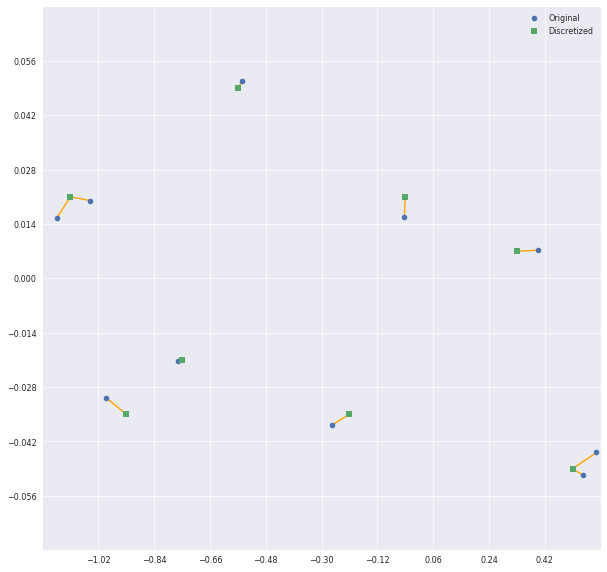

In [92]:
# Discretization parameters
state_size = (10, 10)
window_size = (env.observation_space.high - env.observation_space.low)/state_size

state_grid = create_discretization_grid(env.observation_space.low, env.observation_space.high)
samples = np.array([env.observation_space.sample() for i in range(10)])
discretized_samples = np.array([get_discrete_state(sample, window_size, env) for sample in samples])
visualize_samples(samples, discretized_samples, state_grid, env.observation_space.low, env.observation_space.high)

## Q-Learning

In [8]:
env = gym.make('MountainCar-v0')
state_size = (10, 10)
window_size = (env.observation_space.high - env.observation_space.low)/state_size
num_episodes = 500
max_step = 1000
env._max_episode_steps = max_step

q_params = {
    "gamma": 0.9,
    "alpha": 0.1,
    "alpha_decay_rate": 0,
    "min_alpha": 0.1,
    "epsilon": 1.0,
    "epsilon_decay_rate": 0,
    "min_epsilon": 0.1
}

q_params["epsilon_decay_rate"] = (q_params["epsilon"] - q_params["min_epsilon"])/(num_episodes//2)
q_params["alpha_decay_rate"] = (q_params["alpha"] - q_params["min_alpha"])/(num_episodes//2)


In [9]:
stats_q = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes),
        selector_dist=None)

q_agent = QLearningAgent(action_size=env.action_space.n, state_size=state_size, **q_params)

for episode in range(num_episodes):
    done = False
    success = False
    step = 0

    start = time.time()
    obs = env.reset()
    state = get_discrete_state(obs, window_size, env)

    while not done:
        action = q_agent.policy(state)
        next_obs, reward, done, _ = env.step(action)
        next_state = get_discrete_state(next_obs, window_size, env)

        if next_obs[0] >= env.goal_position:
            q_agent.Q[next_state + (action,)] = 0
            success = True
        else:
            q_agent.update(state, next_state, action, reward)
        state = next_state

        step+=1
        stats_q.episode_rewards[episode] += reward
        stats_q.episode_lengths[episode] = step 
    
    q_agent.decay_epsilon(episode)
    #q_agent.decay_alpha(episode)

    if episode % 100 == 0:
        print("Episode {}/{}, Reward {}, Total steps {}, Epsilon: {:.2f}, Alpha: {:.2f}, Time {:.3f}".format(episode, num_episodes, stats_q.episode_rewards[episode], stats_q.episode_lengths[episode], q_agent.epsilon, q_agent.alpha, time.time()-start))

Episode 0/500, Reward -1000.0, Total steps 1000.0, Epsilon: 1.00, Alpha: 0.10, Time 0.116
Episode 100/500, Reward -1000.0, Total steps 1000.0, Epsilon: 0.64, Alpha: 0.10, Time 0.101
Episode 200/500, Reward -232.0, Total steps 232.0, Epsilon: 0.28, Alpha: 0.10, Time 0.018
Episode 300/500, Reward -230.0, Total steps 230.0, Epsilon: 0.10, Alpha: 0.10, Time 0.017
Episode 400/500, Reward -1000.0, Total steps 1000.0, Epsilon: 0.10, Alpha: 0.10, Time 0.085


## Statistics

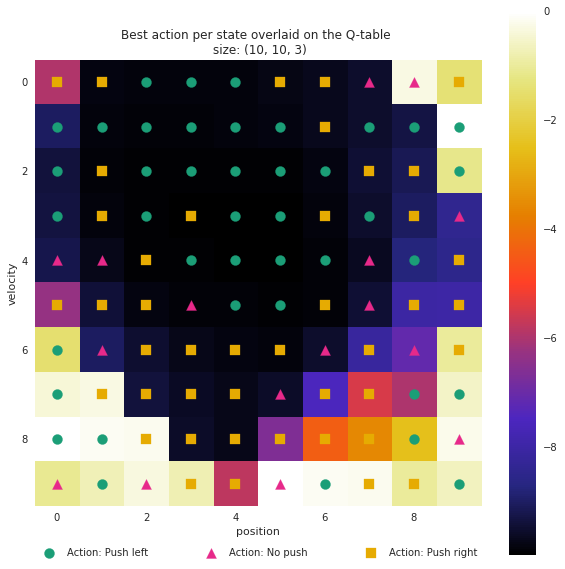

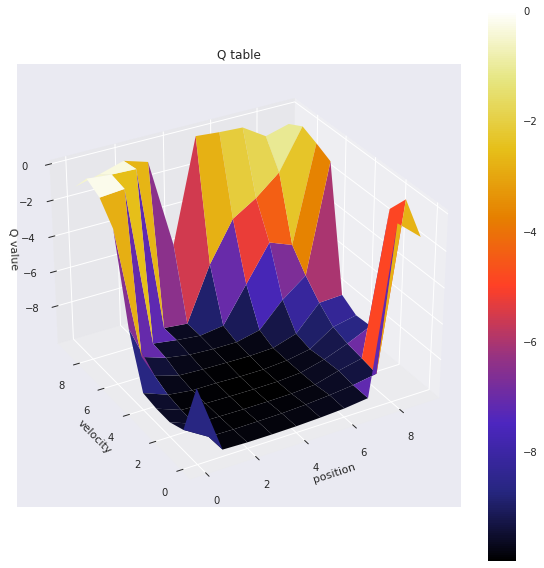

In [10]:
act_dict = {
    0: "Push left",
    1: "No push",
    2: "Push right"
}

act_symbol = {
    0:  "o",
    1: "^",
    2: "s",
}

#act_color = [plt.cm.viridis_r(i) for i in np.linspace(0.1, 1, 3, endpoint=False)]
act_color = cm.Dark2(np.linspace(0.1, 1, 3, endpoint=False))

plot_q_table(   q_table=q_agent.Q, 
                action_names=act_dict, 
                symbols=act_symbol, 
                colors=act_color,
                title="Best action per state overlaid on the Q-table",
                axis_names=["position", "velocity"])
plot_q_table_3d(q_table=q_agent.Q, 
                state_size=state_size,
                title="Q table",
                axis_names=["position", "velocity", "Q value"])

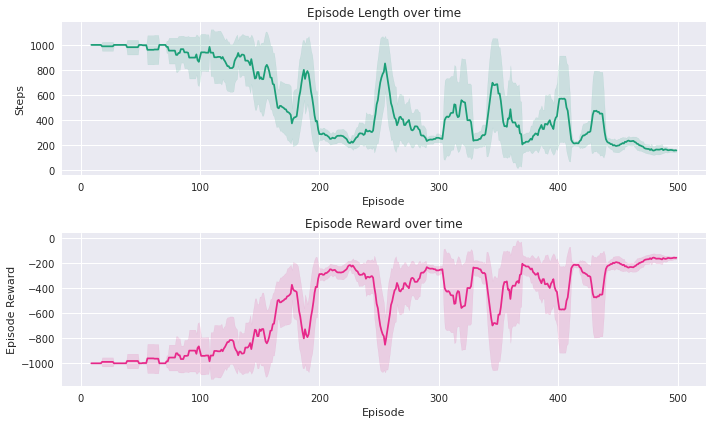

In [11]:
plot_stats2(stats_q, colors=act_color)

## Con-RL

In [12]:
env = gym.make('MountainCar-v0')
bins = [10, 10]
window_size = (env.observation_space.high - env.observation_space.low)/bins
num_episodes = 500
max_step = 1000
env._max_episode_steps = max_step

q_params = {
    "gamma": 0.9,
    "alpha": 0.1,
    "alpha_decay_rate": 0,
    "min_alpha": 0.1,
    "epsilon": 1.0,
    "epsilon_decay_rate": 0,
    "min_epsilon": 0.1
}

q_params["epsilon_decay_rate"] = (q_params["epsilon"] - q_params["min_epsilon"])/(num_episodes//2)
q_params["alpha_decay_rate"] = (q_params["alpha"] - q_params["min_alpha"])/(num_episodes//2)

mlgng_params = {
    "ndim": 2, 
    "e_w":0.5, 
    "e_n":0.1, 
    "l":10, 
    "a":0.5, 
    "b":1-0.05, # Java impl. does it like this
    "k":1000.0, 
    "max_nodes": 10, 
    "max_age": 10
}

In [22]:
stats_cr = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes),
        selector_dist=np.zeros((num_episodes, max_step)).astype(int))

conrl = ConRL(action_size=env.action_space.n, state_size=state_size, update_threshold=10)
conrl.init_support(**q_params)
conrl.init_mlgng(**mlgng_params)

for episode in range(num_episodes):
    done = False
    success = False
    step = 0

    start = time.time()
    obs = env.reset()

    state = get_discrete_state(obs, window_size, env)
    while not done:
        next_state, reward, done, selected = conrl.step(state, env, window_size=window_size, discretize=get_discrete_state)
        state = next_state
        
        stats_cr.episode_rewards[episode] += reward
        stats_cr.episode_lengths[episode] = step
        stats_cr.selector_dist[episode][step] = selected

        step+=1
        if step >= max_step:
            break
    
    conrl.support.decay_epsilon(episode)
    if episode % 100 == 0:
        print("Episode {}/{}, Reward {}, Total steps {}, Epsilon: {:.2f}, Alpha: {:.2f}, Time {:.3f}".format(episode, num_episodes, stats_cr.episode_rewards[episode], stats_cr.episode_lengths[episode], conrl.support.epsilon, conrl.support.alpha, time.time()-start))
        conrl.mlgng.stats(one_line=True)

Episode 0/500, Reward -1000.0, Total steps 999.0, Epsilon: 1.00, Alpha: 0.10, Time 0.169
	 MLGNG nodes per action layer: 0 0 0
Episode 100/500, Reward -117.0, Total steps 116.0, Epsilon: 0.64, Alpha: 0.10, Time 0.066
	 MLGNG nodes per action layer: 2 0 3
Episode 200/500, Reward -252.0, Total steps 251.0, Epsilon: 0.28, Alpha: 0.10, Time 0.218
	 MLGNG nodes per action layer: 10 10 10
Episode 300/500, Reward -233.0, Total steps 232.0, Epsilon: 0.10, Alpha: 0.10, Time 0.301
	 MLGNG nodes per action layer: 10 10 10
Episode 400/500, Reward -219.0, Total steps 218.0, Epsilon: 0.10, Alpha: 0.10, Time 0.278
	 MLGNG nodes per action layer: 10 10 10


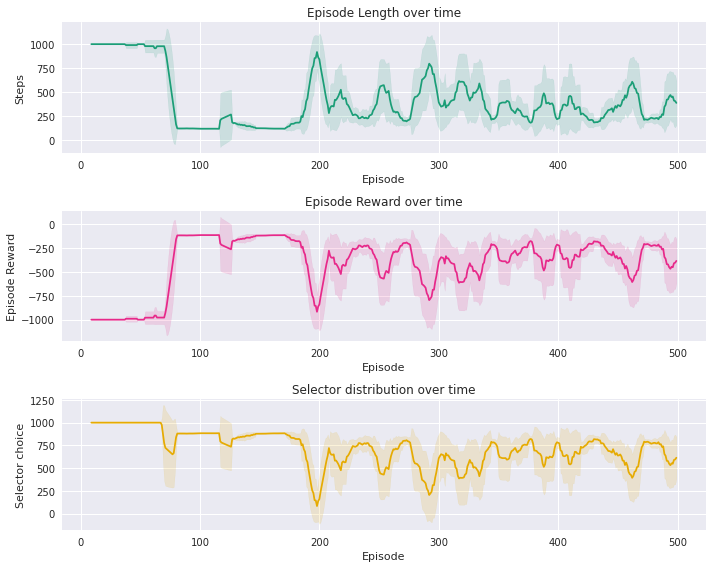

In [23]:
plot_stats2(stats_cr, selector=True, colors=act_color)

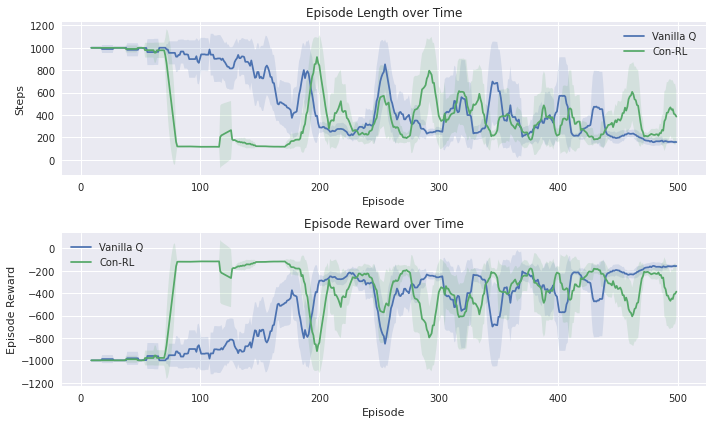

In [24]:
plot_stats_comparison({"Vanilla Q": stats_q, "Con-RL": stats_cr})

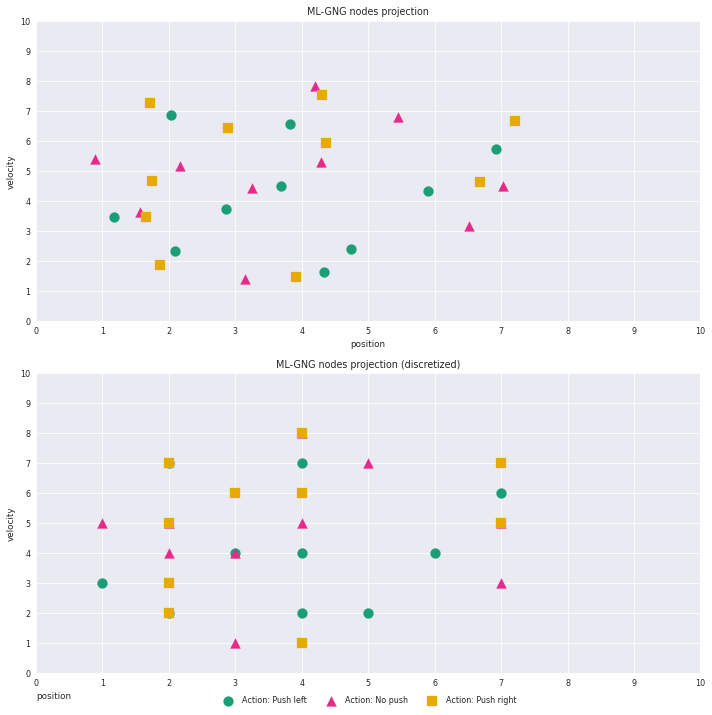

In [101]:

fig, ax = plt.subplots(nrows=2, figsize=(10, 10))

project_mlgng_actions(mlgng=conrl.mlgng, 
                        state_size=state_size, 
                        action_names=act_dict, 
                        symbols=act_symbol, 
                        colors=act_color,
                        axis_names=["position", "velocity"],
                        title="ML-GNG nodes projection",
                        round=False,
                        ax=ax[0],
                        legend=False)

project_mlgng_actions(mlgng=conrl.mlgng, 
                        state_size=state_size, 
                        action_names=act_dict, 
                        symbols=act_symbol, 
                        colors=act_color,
                        axis_names=["position", "velocity"],
                        title="ML-GNG nodes projection (discretized)",
                        round=True,
                        ax=ax[1],)


fig.tight_layout()

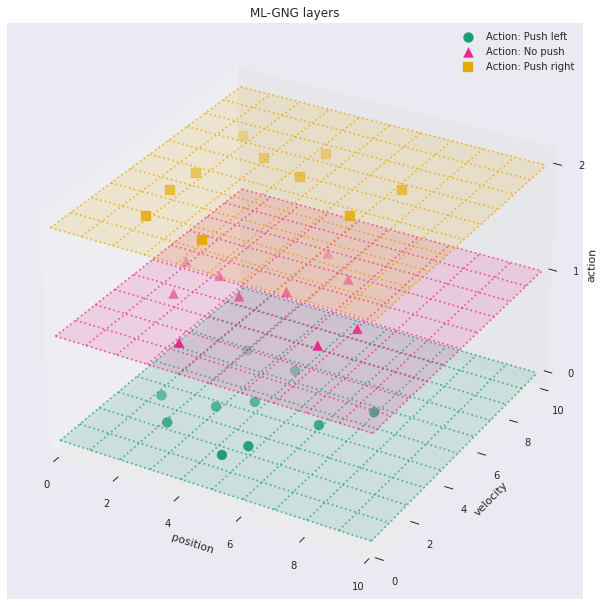

In [26]:
plot_mlgng_actions_3d(mlgng=conrl.mlgng, 
                        state_size=state_size, 
                        action_names=act_dict, 
                        symbols=act_symbol, 
                        colors=act_color,   
                        axis_names=["position", "velocity", "action"])


## Selector choice conundrum

In [31]:
from collections import defaultdict
import itertools

conrl_state_actions = defaultdict(lambda: [])

for x, y in list(itertools.product(np.arange(state_size[0]), 
                                    np.arange(state_size[1]))):
    u = (x, y)
    best_a, _, _, _ = conrl._simple_action_selector(u)
    conrl_state_actions[best_a].append(u)

q_state_actions = defaultdict(lambda: [])

q_agent.exploitation = True
for x, y in list(itertools.product(np.arange(state_size[0]), 
                                    np.arange(state_size[1]))):
    u = (x, y)
    best_a = q_agent.policy(u)
    q_state_actions[best_a].append(u)
q_agent.exploitation = True


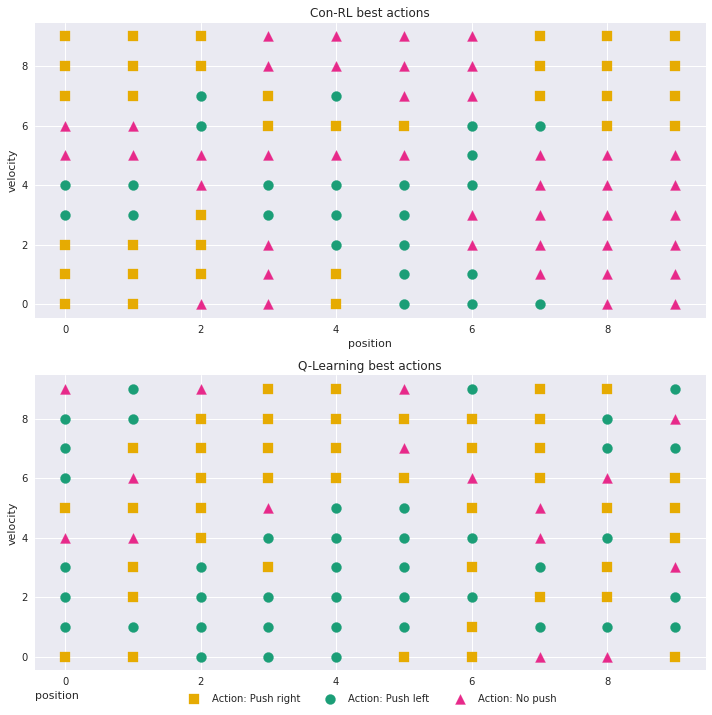

In [87]:
fig, ax = plt.subplots(nrows=2, figsize=(10, 10))

project_best_actions(conrl_state_actions,
                    action_names=act_dict, 
                    symbols=act_symbol,
                    colors=act_color,
                    axis_names=["position", "velocity"],
                    title="Con-RL best actions",
                    ax=ax[0],
                    legend=False)

project_best_actions(q_state_actions,
                    action_names=act_dict, 
                    symbols=act_symbol,
                    colors=act_color,
                    axis_names=["position", "velocity"],
                    title="Q-Learning best actions",
                    ax=ax[1])
fig.tight_layout()